In [16]:
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from openbabel import pybel
import pandas as pd
import re
from IPython.display import display
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole


In [17]:
#def convert_mol2_to_sdf(mol2_file, sdf_file):
#    mol2_mols = pybel.readfile("mol2", mol2_file)
#    out_sdf = pybel.Outputfile("sdf", sdf_file, overwrite=True)

#    for mol in mol2_mols:
#        out_sdf.write(mol)

#    out_sdf.close()

# Example usage
#convert_mol2_to_sdf('/Users/lkv206/Downloads/STRAIN_FILTER/example.mol2', 'output.sdf')

In [18]:
def Mol2MolSupplier (file = None):
    mol2_names = [] #Make a list to hold the molecule names
    mol2_mols = {} #Make a dictionary
    with open(file, 'r') as f:
        fileend = os.fstat(f.fileno()).st_size
        count = 0
        line = f.readline()

        while not f.tell() == fileend:
            if line.startswith("#") or line == '\n':
                line = f.readline()
            if line.startswith("@<TRIPOS>MOLECULE"):
                count += 1
                mol = []
                mol.append(line)
                line = f.readline()
                if line != "\n" and line.split()[0].strip() not in mol2_names:
                    name = line.split()[0].strip()
                    print(name)
                else:
                    name = "mol2Number" + str(count)
                    print(name)

                while not line.startswith("@<TRIPOS>MOLECULE"):
                    mol.append(line)
                    line = f.readline()

                    if f.tell() == fileend:
                        mol.append(line)
                        break
                block = ",".join(mol).replace(',','')
                m = Chem.rdmolfiles.MolFromMol2Block(block, sanitize=False, removeHs = False)
                mol2_names.append(name)
                mol2_mols[name] = m
    return(mol2_names, mol2_mols)

mol2_names, mol2_mols = Mol2MolSupplier(file='/Users/lkv206/Downloads/STRAIN_FILTER/example.mol2')
print(mol2_names)
print(mol2_mols)

ZINC000191583186
ZINC000159533726
ZINC000151228439
['ZINC000191583186', 'ZINC000159533726', 'ZINC000151228439']
{'ZINC000191583186': <rdkit.Chem.rdchem.Mol object at 0x169e79d90>, 'ZINC000159533726': <rdkit.Chem.rdchem.Mol object at 0x169e79e00>, 'ZINC000151228439': <rdkit.Chem.rdchem.Mol object at 0x169e789e0>}


In [19]:
def custom_sdmolsupplier(file_path):
    if not file_path:
        raise ValueError("File path is required.")

    suppl = Chem.SDMolSupplier(file_path)

    sdf_names = []
    sdf_mols = {}

    for mol in suppl:
        if mol is not None:
            name = mol.GetProp('_Name') if mol.HasProp('_Name') else f'UnnamedMol_{len(sdf_names)}'
            # openbabel converion adds a 'none' that has to be split from name 
            name = name.split()[0]
            sdf_names.append(name)
            sdf_mols[name] = mol

    return sdf_names, sdf_mols

# Example usage
sdf_names, sdf_mols = custom_sdmolsupplier('output.sdf')
print(sdf_names)
print(sdf_mols)

['ZINC000191583186', 'ZINC000159533726', 'ZINC000151228439']
{'ZINC000191583186': <rdkit.Chem.rdchem.Mol object at 0x169e78200>, 'ZINC000159533726': <rdkit.Chem.rdchem.Mol object at 0x169e78580>, 'ZINC000151228439': <rdkit.Chem.rdchem.Mol object at 0x169e78cf0>}


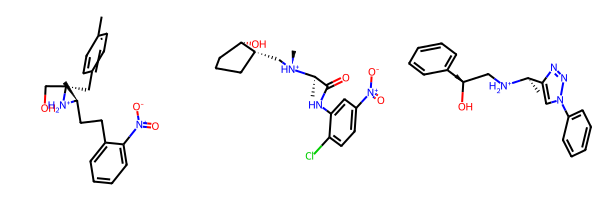

In [20]:
from IPython.display import display

# Assuming sdf_mols is your dictionary of rdchem.Mol objects
mols = list(sdf_mols.values())

# Now create a grid image of the molecules
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200,200))  # adjust the parameters as needed

# Display the image
display(img)


# Assuming sdf_mols is your dictionary of rdchem.Mol objects
mols = list(mol2_mols.values())

# Fix the Pre-condition Violation (why doesn't it run without this?)
#for mol in mols:
    #Chem.SanitizeMol(mol)
    #for atom in mol.GetAtoms():
        #atom.UpdatePropertyCache()
        #atom.GetExplicitValence()

# Now create a grid image of the molecules
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200,200))  # adjust the parameters as needed

# Display the image
display(img)

# Code will give valence error, keeping in case it's important. 

It's strange that this doesn't work without sanitization, yet explicitly avoided in his mol2molsupplier function. I am worried that it's somehow important for the strain matching, but I don't know if it cares? One way to quickly test around it is to just call the Torsion_Strain.py on a "sanitzed" version and my SDF conversion and hope that it matches. 

The SDF isn't a perfect match unfortunately. So it means I need to understand what's going on. 

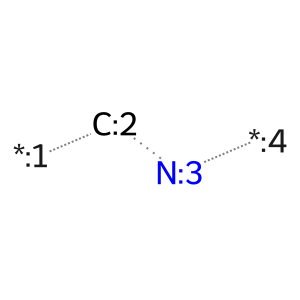

In [21]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

# Define the SMARTS pattern
smarts = '[*:1]~[CX4:2]!@[n:3]~[*:4]'

# Create a molecule from the SMARTS pattern
mol = Chem.MolFromSmarts(smarts)

# If the molecule is valid, draw it
if mol:
    # Use RDKit to draw the molecule
    drawing = Draw.MolToImage(mol)
else:
    drawing = "Invalid SMARTS pattern."

drawing


In [22]:

def unit(a):
    # The argument should be a NumPy array with 1 axis
    return(a / sqrt(np.dot(a,a))) #Scales a by its norm

def dihedral(a_1, a_2, a_3, a_4):
    # The arguments should all be NumPy arrays with 1 axis and length 3
    # These atoms should be in order, with a_2 and a_3 defining the bond
    # of interest

    # The 3 displacement vectors:
    b_1 = a_2 - a_1
    b_2 = a_3 - a_2
    b_3 = a_4 - a_3

    n_1 = unit(np.cross(b_1, b_2))
    n_2 = unit(np.cross(b_2, b_3))

    # Imagine the first atom (a_1) is above the middle bond (from a_2 to a_3),
    # so that b_1 points downward. Then n_1 points out of the page

    m = unit(np.cross(n_1, b_2))
    # I moved the normalization to be after the cross product. Moving
    # the normalization should not change the end result because the cross
    # product commutes with scalar multiplication and ||n_1|| = 1

    # Looking down b_2, we can consider n_1 to be the x-axis and
    # m to be the y-axis. Then the dihedral angle is the angle that
    # n_2 makes with the x-axis when projected into this plane. Since dihedral
    # angles are measured going clockwise, we need to negate the angle
    # that we get back from atan
    x = np.dot(n_1, n_2) #Project n_2 onto n_1
    y = np.dot(m, n_2) #Project n_2 onto m
    return(-atan2(y,x) * 180 / pi) #Return the angle in degrees

def ang_diff(theta_1, theta_2):
    # (-180,180] -> [0, 360)
    if theta_1 < 0:
        theta_1 += 360
    if theta_2 < 0:
        theta_2 += 360
    del_theta = (theta_1 - theta_2) % 360 #Angular difference
    # [0, 360) -> (-180, 180]
    if del_theta > 180:
        del_theta -= 360
    return(del_theta)
    # Test this works: ang_diff(0, 179), ang_diff(0, -179),
    # and ang_diff(-179, 179)


In [23]:
def select_unique_columns_rounded(df):
    # Round the DataFrame to the 8th decimal place
    df_rounded = df.round(8)

    # Select the first column of df_rounded
    first_column = df_rounded.iloc[:, 0]

    # Select the rest of the columns where the rows have different values
    unique_columns = df_rounded.iloc[:, 1:].loc[:, df_rounded.iloc[:, 1:].nunique() > 1]

    # Concatenate the first column and the unique columns
    df_unique = pd.concat([first_column, unique_columns], axis=1)

    # Return the new DataFrame
    return df_unique

In [24]:
# Set the maximum number of rows and columns to display to None, which means unlimited
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Define a regular expression for the separator
sep = r',(?![^[]*\])'  # Pass the compiled regular expression pattern as a string


# Import the first rows and concatenate them
df_sdf1 = pd.read_csv('output_sdf_Torsion_Strain.csv', sep=sep, header=None, nrows=1)

df_mol21 = pd.read_csv('example_Torsion_Strain.csv', sep=sep, header=None, nrows=1)

df_1 = pd.concat([df_sdf1, df_mol21], ignore_index=True)

# Import the second row and concatenate them
df_sdf2 = pd.read_csv('output_sdf_Torsion_Strain.csv', sep=sep, header=None, skiprows=1, nrows=1)

df_mol22 = pd.read_csv('example_Torsion_Strain.csv', sep=sep, header=None, skiprows=1, nrows=1)

df_2 = pd.concat([df_sdf2, df_mol22], ignore_index=True)

# Import the third row and concatenate them
df_sdf3 = pd.read_csv('output_sdf_Torsion_Strain.csv', sep=sep, header=None, skiprows=2, nrows=1)

df_mol23 = pd.read_csv('example_Torsion_Strain.csv', sep=sep, header=None, skiprows=2, nrows=1) 

df_3 = pd.concat([df_sdf3, df_mol23], ignore_index=True)

# Create a new DataFrame with the desired column
df_label = pd.DataFrame({'origin': ['sdf', 'example']})

# Reset the index of df_label
df_label = df_label.reset_index(drop=True)

# Concatenate the new DataFrame with df_1, df_2, and df_3 and drop the index
df_1 = pd.concat([df_label, df_1.reset_index(drop=True)], axis=1)
df_2 = pd.concat([df_label, df_2.reset_index(drop=True)], axis=1)
df_3 = pd.concat([df_label, df_3.reset_index(drop=True)], axis=1)

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_7572/4179623216.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_sdf1 = pd.read_csv('output_sdf_Torsion_Strain.csv', sep=sep, header=None, nrows=1)
/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_7572/4179623216.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_mol21 = pd.read_csv('example_Torsion_Strain.csv', sep=sep, header=None, nrows=1)
/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_7572/4179623216.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separ

In [25]:
display(df_1)
display(df_2)
display(df_3)

,origin,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93
0,sdf,ZINC000191583186,5.60522,5.056429,NaN,4,1.514902,1.472042,1.561076,"""[11, 10, 12, 13]""",-79.998769,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,8,1.16295,1.013876,NaN,"""[12, 10, 9, 6]""",-159.996786,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,7,1.162767,1.013766,NaN,"""[7, 6, 9, 10]""",-159.99872,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,5,1.040802,0.890317,1.24526,"""[15, 14, 13, 12]""",0.273439,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,3,0.345286,0.339143,0.35149,"""[4, 5, 6, 7]""",59.993486,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,1,0.345222,0.339081,0.351424,"""[5, 6, 7, 8]""",60.00831,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.026354,0.013789,0.039187,"""[14, 19, 20, 21]""",-0.004009,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6,0.006708,-0.022299,0.037155,"""[23, 4, 5, 6]""",89.992702,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,2,0.000229,-0.003285,0.003759,"""[10, 12, 13, 14]""",-179.997919,[!#1:1][CX4H2:2]!@[CX4H2:3][!#1:4],specific,exact,False
1,example,ZINC000191583186,5.62173,5.072461,NaN,4,1.514902,1.472042,1.561076,"""[15, 13, 16, 17]""",-79.998769,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,8,1.16295,1.013876,NaN,"""[16, 13, 10, 6]""",-159.996786,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,7,1.162767,1.013766,NaN,"""[8, 6, 10, 13]""",-159.99872,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,5,1.040802,0.890317,1.24526,"""[19, 18, 17, 16]""",0.273439,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,3,0.345286,0.339143,0.35149,"""[4, 5, 6, 8]""",59.993486,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,1,0.345222,0.339081,0.351424,"""[5, 6, 8, 9]""",60.00831,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.042865,0.029821,0.056206,"""[22, 23, 24, 26]""",0.445858,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6,0.006708,-0.022299,0.037155,"""[27, 4, 5, 6]""",89.992702,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,2,0.000229,-0.003285,0.003759,"""[13, 16, 17, 18]""",-179.997919,[!#1:1][CX4H2:2]!@[CX4H2:3][!#1:4],specific,exact,False


,origin,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
0,sdf,ZINC000159533726,3.440838,2.428910,NaN,4,2.120636,1.283213,NaN,"""[15, 1, 2, 3]""",-120.006155,[NH1:1][CX4:2]!@[CX3:3]=[O:4],specific,exact,False,0,0.875247,0.773987,0.996252,"""[13, 5, 4, 2]""",-150.004143,"""[a:1][a:2]!@[NH1:3][C,c:4]""",specific,exact,False,3,0.39562,0.388804,0.402515,"""[15, 17, 18, 19]""",-61.389633,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.026409,0.013842,0.039243,"""[6, 7, 8, 9]""",0.005349,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5,0.011319,-0.012464,0.0357,"""[0, 1, 15, 16]""",-179.992537,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,6,0.011141,-0.012632,0.03551,"""[18, 17, 15, 1]""",179.996269,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1,0.000466,-0.005841,0.00675,"""[3, 2, 4, 5]""",0.005415,[O:1]=[CX3:2]!@[NX3H1:3][!#1:4],specific,exact,False
1,example,ZINC000159533726,3.441375,2.429431,NaN,4,2.120636,1.283213,NaN,"""[16, 1, 3, 4]""",-120.006155,[NH1:1][CX4:2]!@[CX3:3]=[O:4],specific,exact,False,0,0.875247,0.773987,0.996252,"""[14, 6, 5, 3]""",-150.004143,"""[a:1][a:2]!@[NH1:3][C,c:4]""",specific,exact,False,3,0.39562,0.388804,0.402515,"""[16, 19, 20, 22]""",-61.389633,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.026946,0.014363,0.039797,"""[12, 8, 9, 11]""",0.019719,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5,0.011319,-0.012464,0.0357,"""[0, 1, 16, 18]""",-179.992537,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,6,0.011141,-0.012632,0.03551,"""[20, 19, 16, 1]""",179.996269,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1,0.000466,-0.005841,0.00675,"""[4, 3, 5, 6]""",0.005415,[O:1]=[CX3:2]!@[NX3H1:3][!#1:4],specific,exact,False


,origin,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,sdf,ZINC000151228439,2.625485,2.148132,3.224854,4,1.22614,1.06247,1.448703,"""[13, 1, 2, 3]""",160.000329,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1,0.707273,0.565726,0.893202,"""[8, 7, 4, 6]""",-120.002110,"""[a:1][c:2]!@[CX4H0:3][N,O:4]""",specific,exact,False,0,0.345013,0.338874,0.351211,"""[2, 3, 4, 5]""",60.001999,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.193996,0.133122,0.261071,"""[23, 13, 1, 2]""",-120.315336,"""[a:1][c:2]!@[CX4H1:3][N,O:4]""",specific,exact,False,3,0.142086,0.060724,0.235332,"""[17, 16, 15, 22]""",0.293234,[*:1]~[cX3:2]!@[n:3]~[*:4],general,exact,False,5,0.010978,-0.012785,0.035335,"""[4, 3, 2, 1]""",179.999104,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False
1,example,ZINC000151228439,3.192153,2.776743,3.720130,4,1.22614,1.06247,1.448703,"""[16, 1, 3, 6]""",160.000329,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,2,0.865586,0.798172,0.941350,"""[3, 1, 16, 26]""",-120.315336,[!#1:1][CX4:2]!@[CX3H0:3][!#1:4],specific,exact,False,3,0.707273,0.565726,0.893202,"""[11, 10, 7, 9]""",-120.002110,"""[a:1][c:2]!@[CX4H0:3][N,O:4]""",specific,exact,False,1,0.345013,0.338874,0.351211,"""[3, 6, 7, 8]""",60.001999,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.037163,0.024285,0.050329,"""[20, 19, 18, 25]""",0.293234,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5,0.010978,-0.012785,0.035335,"""[7, 6, 3, 1]""",179.999104,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False


In [26]:
def select_unique_columns(df):
    # Reset the index of df
    df = df.reset_index(drop=True)

    # Select the first two columns of df
    first_two_columns = df.iloc[:, :2]

    # Select the rest of the columns where the rows have different values
    unique_columns = df.iloc[:, 2:].loc[:, df.iloc[:, 2:].nunique() > 1]

    # Concatenate the first two columns and the unique columns
    df_unique = pd.concat([first_two_columns, unique_columns], axis=1)

    df_unique = df_unique.reset_index(drop=True)

    # Return the new DataFrame
    return df_unique

In [27]:
df_1_unique = select_unique_columns(df_1)
df_2_unique = select_unique_columns(df_2)
df_3_unique = select_unique_columns(df_3)

In [28]:
print(df_1_unique.shape, df_2_unique.shape, df_3_unique.shape)

(2, 29) (2, 23) (2, 36)


In [29]:
display(df_1_unique)
display(df_2_unique)
display(df_3_unique)

,origin,0,1,2,5,6,7,8,9,18,25,26,28,29,38,39,48,58,65,66,67,68,69,75,76,77,78,79,88
0,sdf,ZINC000191583186,5.60522,5.056429,1.514902,1.472042,1.561076,"""[11, 10, 12, 13]""",-79.998769,"""[12, 10, 9, 6]""",1.162767,1.013766,"""[7, 6, 9, 10]""",-159.99872,"""[15, 14, 13, 12]""",0.273439,"""[4, 5, 6, 7]""","""[5, 6, 7, 8]""",0.026354,0.013789,0.039187,"""[14, 19, 20, 21]""",-0.004009,0.006708,-0.022299,0.037155,"""[23, 4, 5, 6]""",89.992702,"""[10, 12, 13, 14]"""
1,example,ZINC000191583186,5.62173,5.072461,1.514902,1.472042,1.561076,"""[15, 13, 16, 17]""",-79.998769,"""[16, 13, 10, 6]""",1.162767,1.013766,"""[8, 6, 10, 13]""",-159.99872,"""[19, 18, 17, 16]""",0.273439,"""[4, 5, 6, 8]""","""[5, 6, 8, 9]""",0.042865,0.029821,0.056206,"""[22, 23, 24, 26]""",0.445858,0.006708,-0.022299,0.037155,"""[27, 4, 5, 6]""",89.992702,"""[13, 16, 17, 18]"""


,origin,0,1,2,8,18,28,35,36,37,38,39,45,46,47,48,49,58,65,66,67,68,69
0,sdf,ZINC000159533726,3.440838,2.428910,"""[15, 1, 2, 3]""","""[13, 5, 4, 2]""","""[15, 17, 18, 19]""",0.026409,0.013842,0.039243,"""[6, 7, 8, 9]""",0.005349,0.011319,-0.012464,0.0357,"""[0, 1, 15, 16]""",-179.992537,"""[18, 17, 15, 1]""",0.000466,-0.005841,0.00675,"""[3, 2, 4, 5]""",0.005415
1,example,ZINC000159533726,3.441375,2.429431,"""[16, 1, 3, 4]""","""[14, 6, 5, 3]""","""[16, 19, 20, 22]""",0.026946,0.014363,0.039797,"""[12, 8, 9, 11]""",0.019719,0.011319,-0.012464,0.0357,"""[0, 1, 16, 18]""",-179.992537,"""[20, 19, 16, 1]""",0.000466,-0.005841,0.00675,"""[4, 3, 5, 6]""",0.005415


,origin,0,1,2,3,8,14,15,16,17,18,19,20,24,25,26,27,28,29,30,34,35,36,37,38,39,40,44,45,46,47,48,49,50,51,58
0,sdf,ZINC000151228439,2.625485,2.148132,3.224854,"""[13, 1, 2, 3]""",1,0.707273,0.565726,0.893202,"""[8, 7, 4, 6]""",-120.002110,"""[a:1][c:2]!@[CX4H0:3][N,O:4]""",0,0.345013,0.338874,0.351211,"""[2, 3, 4, 5]""",60.001999,[!#1:1][CX4:2]!@[CX4:3][!#1:4],2,0.193996,0.133122,0.261071,"""[23, 13, 1, 2]""",-120.315336,"""[a:1][c:2]!@[CX4H1:3][N,O:4]""",3,0.142086,0.060724,0.235332,"""[17, 16, 15, 22]""",0.293234,[*:1]~[cX3:2]!@[n:3]~[*:4],general,"""[4, 3, 2, 1]"""
1,example,ZINC000151228439,3.192153,2.776743,3.720130,"""[16, 1, 3, 6]""",2,0.865586,0.798172,0.941350,"""[3, 1, 16, 26]""",-120.315336,[!#1:1][CX4:2]!@[CX3H0:3][!#1:4],3,0.707273,0.565726,0.893202,"""[11, 10, 7, 9]""",-120.002110,"""[a:1][c:2]!@[CX4H0:3][N,O:4]""",1,0.345013,0.338874,0.351211,"""[3, 6, 7, 8]""",60.001999,[!#1:1][CX4:2]!@[CX4:3][!#1:4],0,0.037163,0.024285,0.050329,"""[20, 19, 18, 25]""",0.293234,[a:1][a:2]!@[NX3:3][!#1:4],specific,"""[7, 6, 3, 1]"""


In [30]:
def select_unique_columns_rounded(df):
    # Reset the index of df
    df = df.reset_index(drop=True)

    # Round the DataFrame to the 8th decimal place
    df_rounded = df.round(8)

    # Select the first two columns of df_rounded
    first_two_columns = df_rounded.iloc[:, :2]

    # Select the rest of the columns where the rows have different values
    unique_columns = df_rounded.iloc[:, 2:].loc[:, df_rounded.iloc[:, 2:].nunique() > 1]

    # Concatenate the first two columns and the unique columns
    df_unique = pd.concat([first_two_columns, unique_columns], axis=1)

    # Return the new DataFrame
    return df_unique

In [31]:
df_1_r8_unique = select_unique_columns_rounded(df_1)
df_2_r8_unique = select_unique_columns_rounded(df_2)
df_3_r8_unique = select_unique_columns_rounded(df_3)
print(df_1_r8_unique.shape, df_2_r8_unique.shape, df_3_r8_unique.shape)

(2, 17) (2, 15) (2, 35)


In [32]:
display(df_1_r8_unique)
display(df_2_r8_unique)
display(df_3_r8_unique)

,origin,0,1,2,8,18,28,38,48,58,65,66,67,68,69,78,88
0,sdf,ZINC000191583186,5.60522,5.056429,"""[11, 10, 12, 13]""","""[12, 10, 9, 6]""","""[7, 6, 9, 10]""","""[15, 14, 13, 12]""","""[4, 5, 6, 7]""","""[5, 6, 7, 8]""",0.026354,0.013789,0.039187,"""[14, 19, 20, 21]""",-0.004009,"""[23, 4, 5, 6]""","""[10, 12, 13, 14]"""
1,example,ZINC000191583186,5.62173,5.072461,"""[15, 13, 16, 17]""","""[16, 13, 10, 6]""","""[8, 6, 10, 13]""","""[19, 18, 17, 16]""","""[4, 5, 6, 8]""","""[5, 6, 8, 9]""",0.042865,0.029821,0.056206,"""[22, 23, 24, 26]""",0.445858,"""[27, 4, 5, 6]""","""[13, 16, 17, 18]"""


,origin,0,1,2,8,18,28,35,36,37,38,39,48,58,68
0,sdf,ZINC000159533726,3.440838,2.428910,"""[15, 1, 2, 3]""","""[13, 5, 4, 2]""","""[15, 17, 18, 19]""",0.026409,0.013842,0.039243,"""[6, 7, 8, 9]""",0.005349,"""[0, 1, 15, 16]""","""[18, 17, 15, 1]""","""[3, 2, 4, 5]"""
1,example,ZINC000159533726,3.441375,2.429431,"""[16, 1, 3, 4]""","""[14, 6, 5, 3]""","""[16, 19, 20, 22]""",0.026946,0.014363,0.039797,"""[12, 8, 9, 11]""",0.019719,"""[0, 1, 16, 18]""","""[20, 19, 16, 1]""","""[4, 3, 5, 6]"""


,origin,0,1,2,3,8,14,15,16,17,18,19,20,24,25,26,27,28,29,30,34,35,36,37,38,39,40,44,45,46,47,48,50,51,58
0,sdf,ZINC000151228439,2.625485,2.148132,3.224854,"""[13, 1, 2, 3]""",1,0.707273,0.565726,0.893202,"""[8, 7, 4, 6]""",-120.002110,"""[a:1][c:2]!@[CX4H0:3][N,O:4]""",0,0.345013,0.338874,0.351211,"""[2, 3, 4, 5]""",60.001999,[!#1:1][CX4:2]!@[CX4:3][!#1:4],2,0.193996,0.133122,0.261071,"""[23, 13, 1, 2]""",-120.315336,"""[a:1][c:2]!@[CX4H1:3][N,O:4]""",3,0.142086,0.060724,0.235332,"""[17, 16, 15, 22]""",[*:1]~[cX3:2]!@[n:3]~[*:4],general,"""[4, 3, 2, 1]"""
1,example,ZINC000151228439,3.192153,2.776743,3.720130,"""[16, 1, 3, 6]""",2,0.865586,0.798172,0.941350,"""[3, 1, 16, 26]""",-120.315336,[!#1:1][CX4:2]!@[CX3H0:3][!#1:4],3,0.707273,0.565726,0.893202,"""[11, 10, 7, 9]""",-120.002110,"""[a:1][c:2]!@[CX4H0:3][N,O:4]""",1,0.345013,0.338874,0.351211,"""[3, 6, 7, 8]""",60.001999,[!#1:1][CX4:2]!@[CX4:3][!#1:4],0,0.037163,0.024285,0.050329,"""[20, 19, 18, 25]""",[a:1][a:2]!@[NX3:3][!#1:4],specific,"""[7, 6, 3, 1]"""


In [33]:
def select_object_columns(df):
    # Select columns where the data type is 'object'
    object_columns = df.select_dtypes(include=['object'])

    # Return the new DataFrame
    return object_columns

In [34]:
df_1_r8_unique_objects = select_object_columns(df_1_r8_unique)
df_2_r8_unique_objects = select_object_columns(df_2_r8_unique)
df_3_r8_unique_objects = select_object_columns(df_3_r8_unique)

In [35]:
display(df_1_r8_unique_objects)
display(df_2_r8_unique_objects) 
display(df_3_r8_unique_objects)

,origin,0,8,18,28,38,48,58,68,78,88
0,sdf,ZINC000191583186,"""[11, 10, 12, 13]""","""[12, 10, 9, 6]""","""[7, 6, 9, 10]""","""[15, 14, 13, 12]""","""[4, 5, 6, 7]""","""[5, 6, 7, 8]""","""[14, 19, 20, 21]""","""[23, 4, 5, 6]""","""[10, 12, 13, 14]"""
1,example,ZINC000191583186,"""[15, 13, 16, 17]""","""[16, 13, 10, 6]""","""[8, 6, 10, 13]""","""[19, 18, 17, 16]""","""[4, 5, 6, 8]""","""[5, 6, 8, 9]""","""[22, 23, 24, 26]""","""[27, 4, 5, 6]""","""[13, 16, 17, 18]"""


,origin,0,8,18,28,38,48,58,68
0,sdf,ZINC000159533726,"""[15, 1, 2, 3]""","""[13, 5, 4, 2]""","""[15, 17, 18, 19]""","""[6, 7, 8, 9]""","""[0, 1, 15, 16]""","""[18, 17, 15, 1]""","""[3, 2, 4, 5]"""
1,example,ZINC000159533726,"""[16, 1, 3, 4]""","""[14, 6, 5, 3]""","""[16, 19, 20, 22]""","""[12, 8, 9, 11]""","""[0, 1, 16, 18]""","""[20, 19, 16, 1]""","""[4, 3, 5, 6]"""


,origin,0,8,18,20,28,30,38,40,48,50,51,58
0,sdf,ZINC000151228439,"""[13, 1, 2, 3]""","""[8, 7, 4, 6]""","""[a:1][c:2]!@[CX4H0:3][N,O:4]""","""[2, 3, 4, 5]""",[!#1:1][CX4:2]!@[CX4:3][!#1:4],"""[23, 13, 1, 2]""","""[a:1][c:2]!@[CX4H1:3][N,O:4]""","""[17, 16, 15, 22]""",[*:1]~[cX3:2]!@[n:3]~[*:4],general,"""[4, 3, 2, 1]"""
1,example,ZINC000151228439,"""[16, 1, 3, 6]""","""[3, 1, 16, 26]""",[!#1:1][CX4:2]!@[CX3H0:3][!#1:4],"""[11, 10, 7, 9]""","""[a:1][c:2]!@[CX4H0:3][N,O:4]""","""[3, 6, 7, 8]""",[!#1:1][CX4:2]!@[CX4:3][!#1:4],"""[20, 19, 18, 25]""",[a:1][a:2]!@[NX3:3][!#1:4],specific,"""[7, 6, 3, 1]"""


Now we can see what objects we have that don't match. We can get the rdkit mol objects back in here and then see the atom numbers and the smarts matching. 

In [36]:
sdf_mols

{'ZINC000191583186': <rdkit.Chem.rdchem.Mol at 0x169e78200>,
 'ZINC000159533726': <rdkit.Chem.rdchem.Mol at 0x169e78580>,
 'ZINC000151228439': <rdkit.Chem.rdchem.Mol at 0x169e78cf0>}

{'ZINC000191583186': <rdkit.Chem.rdchem.Mol object at 0x169e78200>, 'ZINC000159533726': <rdkit.Chem.rdchem.Mol object at 0x169e78580>, 'ZINC000151228439': <rdkit.Chem.rdchem.Mol object at 0x169e78cf0>}


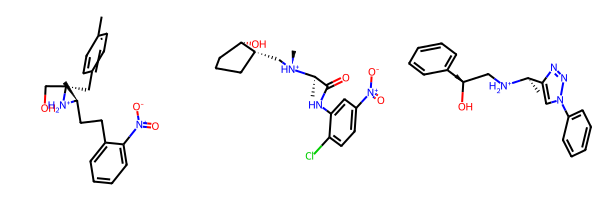

In [37]:
from rdkit.Chem import Draw

# Get the molecules from the dictionary
mols_only_sdf = list(sdf_mols.values())

# Display the molecules
print(sdf_mols)
Draw.MolsToGridImage(mols_only_sdf)

Key, mol2: ZINC000191583186


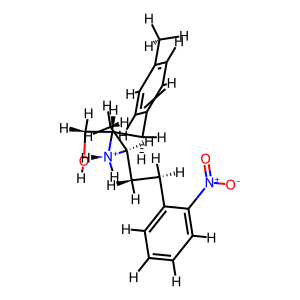

Key, mol2: ZINC000159533726


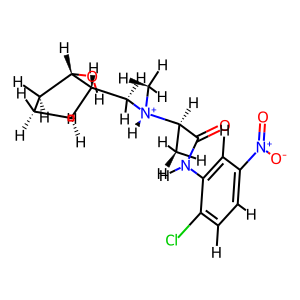

Key, mol2: ZINC000151228439


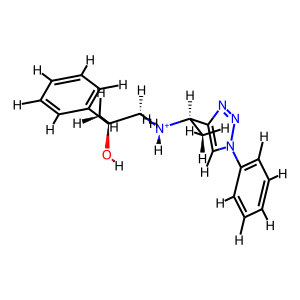

In [38]:
# Get the molecules and their keys from the dictionary
mols_only_mol2 = list(mol2_mols.items())

# Draw the molecules in 2D and label their atom numbers
for key, mol in mols_only_mol2:
    # Draw the molecule with atom indices
    img = Draw.MolToImage(mol, size=(300, 300), addAtomIndices=True)
    
    # Display the key and the image
    print(f"Key, mol2: {key}")
    display(img)

In [39]:
def create_atom_index_dfs(mol_dict):
    df_dict = {}

    for key, mol in mol_dict.items():
        data = [(atom.GetSymbol(), atom.GetIdx()) for atom in mol.GetAtoms()]
        df = pd.DataFrame(data, columns=['Atom', 'Index'])
        df_dict[key] = df

    return df_dict


In [40]:
sdf_indices = create_atom_index_dfs(sdf_mols)
for key, df in sdf_indices.items():
    print(f"SDF: {key}")
    display(df.T)

SDF: ZINC000191583186


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Atom,C,C,C,C,C,C,C,C,O,N,C,C,C,C,C,C,C,C,C,C,N,O,O,C,C
Index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24


SDF: ZINC000159533726


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Atom,C,C,C,O,N,C,C,C,N,O,O,C,C,C,Cl,N,C,C,C,C,C,C,C,O
Index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23


SDF: ZINC000151228439


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Atom,C,C,N,C,C,C,O,C,C,C,C,C,C,C,C,N,C,C,C,C,C,C,N,N
Index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23


In [41]:
mols2_mols = create_atom_index_dfs(mol2_mols)
for key, df in mols2_mols.items():
    print(f"Examples: {key}")
    display(df.T)

Examples: ZINC000191583186


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
Atom,C,C,C,C,C,C,C,H,C,O,N,H,H,C,H,C,C,C,C,C,C,C,C,C,N,O,O,C,C,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H
Index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51


Examples: ZINC000159533726


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
Atom,C,C,H,C,O,N,C,C,C,N,O,O,C,C,C,Cl,N,H,C,C,C,H,C,C,C,C,H,O,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H
Index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46


Examples: ZINC000151228439


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
Atom,C,C,H,N,H,H,C,C,C,O,C,C,C,C,C,C,C,C,N,C,C,C,C,C,C,N,N,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H
Index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46


The difference in length is almost DEFINITELY hydrogen atoms in the index. I think the SDF conversion handled the 3D Aspect okay, at least Maestro agrees. There is also a difference in how resonance/aromaticity is handled via conversion (look at NO2). Hydrogens shouldn't matter as his code excludes (if that part is working), but maybe they do in terms of axial/equitorial? 

One thing we can do add remove the hydrogens like he has, and run it again. 

The issue is that I really can't tell why their are gone, because they are absolutely there in the SDF text and in Maestro. 

In [42]:
from rdkit import Chem

def custom_sdmolsupplier_H(file_path):
    if not file_path:
        raise ValueError("File path is required.")

    suppl_H = Chem.SDMolSupplier(file_path, removeHs=False)

    sdf_names_H = []
    sdf_mols_H = {}

    for mol_H in suppl_H:
        if mol_H is not None:
            name_H = mol_H.GetProp('_Name') if mol_H.HasProp('_Name') else f'UnnamedMol_{len(sdf_names_H)}'
            name_H = name_H.split()[0]
            sdf_names_H.append(name_H)
            sdf_mols_H[name_H] = mol_H

    return sdf_names_H, sdf_mols_H

# Example usage
sdf_names_H, sdf_mols_H = custom_sdmolsupplier_H('output.sdf')
print(sdf_names_H)
print(sdf_mols_H)


['ZINC000191583186', 'ZINC000159533726', 'ZINC000151228439']
{'ZINC000191583186': <rdkit.Chem.rdchem.Mol object at 0x2a1807b50>, 'ZINC000159533726': <rdkit.Chem.rdchem.Mol object at 0x2a18300b0>, 'ZINC000151228439': <rdkit.Chem.rdchem.Mol object at 0x2a1830350>}


{'ZINC000191583186': <rdkit.Chem.rdchem.Mol object at 0x2a1807b50>, 'ZINC000159533726': <rdkit.Chem.rdchem.Mol object at 0x2a18300b0>, 'ZINC000151228439': <rdkit.Chem.rdchem.Mol object at 0x2a1830350>}


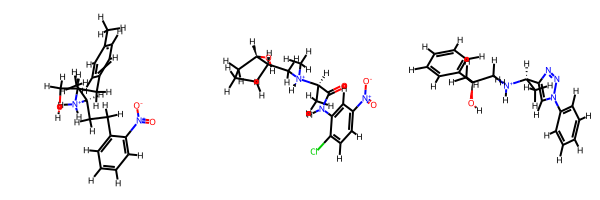

In [43]:

# Get the molecules from the dictionary
mols_only_sdf_H = list(sdf_mols_H.values())

# Display the molecules
print(sdf_mols_H)
Draw.MolsToGridImage(mols_only_sdf_H)

Key, SDF_H: ZINC000191583186


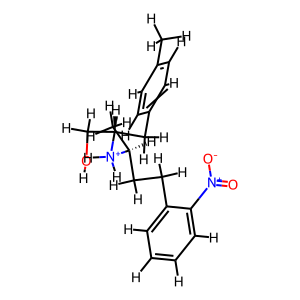

Key, SDF_H: ZINC000159533726


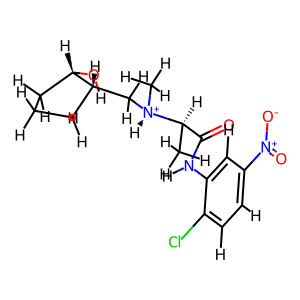

Key, SDF_H: ZINC000151228439


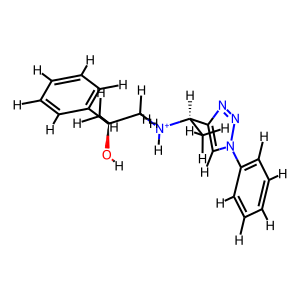

In [44]:
# Get the molecules and their keys from the dictionary
mols_only_sdf_H = list(sdf_mols_H.items())

# Draw the molecules in 2D and label their atom numbers
for key_H, mol_H in mols_only_sdf_H:
    # Draw the molecule with atom indices
    img_H = Draw.MolToImage(mol_H, size=(300, 300), addAtomIndices=True)
    
    # Display the key and the image
    print(f"Key, SDF_H: {key_H}")
    display(img_H)

In [45]:
sdf_indices_H = create_atom_index_dfs(sdf_mols_H)
for key_H, df_H in sdf_indices_H.items():
    print(f"SDF: {key_H}")
    display(df_H.T)

SDF: ZINC000191583186


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
Atom,C,C,C,C,C,C,C,H,C,O,N,H,H,C,H,C,C,C,C,C,C,C,C,C,N,O,O,C,C,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H
Index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51


SDF: ZINC000159533726


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
Atom,C,C,H,C,O,N,C,C,C,N,O,O,C,C,C,Cl,N,H,C,C,C,H,C,C,C,C,H,O,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H
Index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46


SDF: ZINC000151228439


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
Atom,C,C,H,N,H,H,C,C,C,O,C,C,C,C,C,C,C,C,N,C,C,C,C,C,C,N,N,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H
Index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46


In [46]:
print("yay! they match!!!")

yay! they match!!!


In [47]:
# Import the first rows
df_sdf1_H = pd.read_csv('output_sdf_H_Torsion_Strain.csv', sep=sep, header=None, nrows=1)
df_1_H = pd.concat([df_sdf1_H, df_mol21], ignore_index=True)

# Import the second row
df_sdf2_H = pd.read_csv('output_sdf_H_Torsion_Strain.csv', sep=sep, header=None, skiprows=1, nrows=1)
df_2_H = pd.concat([df_sdf2_H, df_mol22], ignore_index=True)

# Import the third row
df_sdf3_H = pd.read_csv('output_sdf_H_Torsion_Strain.csv', sep=sep, header=None, skiprows=2, nrows=1)
df_3_H = pd.concat([df_sdf3_H, df_mol23], ignore_index=True)

# Create a new DataFrame with the desired column
df_label_H = pd.DataFrame({'origin': ['sdf_H', 'example']})

# Reset the index of df_label_H
df_label_H = df_label_H.reset_index(drop=True)

# Concatenate the new DataFrame with df_1_H, df_2_H, and df_3_H and drop the index
df_1_H = pd.concat([df_label_H, df_1_H.reset_index(drop=True)], axis=1)
df_2_H = pd.concat([df_label_H, df_2_H.reset_index(drop=True)], axis=1)
df_3_H = pd.concat([df_label_H, df_3_H.reset_index(drop=True)], axis=1)

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_7572/2476505992.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_sdf1_H = pd.read_csv('output_sdf_H_Torsion_Strain.csv', sep=sep, header=None, nrows=1)
/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_7572/2476505992.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_sdf2_H = pd.read_csv('output_sdf_H_Torsion_Strain.csv', sep=sep, header=None, skiprows=1, nrows=1)
/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_7572/2476505992.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not

In [48]:
df_1_H_r8_unique = select_unique_columns_rounded(df_1_H)
df_2_H_r8_unique = select_unique_columns_rounded(df_2_H)
df_3_H_r8_unique = select_unique_columns_rounded(df_3_H)
print(df_1_H_r8_unique.shape, df_2_H_r8_unique.shape, df_3_H_r8_unique.shape)

(2, 9) (2, 9) (2, 32)


In [49]:
display(df_1_H_r8_unique)
display(df_2_H_r8_unique)
display(df_3_H_r8_unique)

,origin,0,1,2,65,66,67,68,69
0,sdf_H,ZINC000191583186,5.60522,5.056429,0.026354,0.013789,0.039187,"""[18, 23, 24, 25]""",-0.004009
1,example,ZINC000191583186,5.62173,5.072461,0.042865,0.029821,0.056206,"""[22, 23, 24, 26]""",0.445858


,origin,0,1,2,35,36,37,38,39
0,sdf_H,ZINC000159533726,3.440838,2.428910,0.026409,0.013842,0.039243,"""[7, 8, 9, 10]""",0.005349
1,example,ZINC000159533726,3.441375,2.429431,0.026946,0.014363,0.039797,"""[12, 8, 9, 11]""",0.019719


,origin,0,1,2,3,14,15,16,17,18,19,20,24,25,26,27,28,29,30,34,35,36,37,38,39,40,44,45,46,47,50,51
0,sdf_H,ZINC000151228439,2.625485,2.148132,3.224854,1,0.707273,0.565726,0.893202,"""[11, 10, 7, 9]""",-120.002110,"""[a:1][c:2]!@[CX4H0:3][N,O:4]""",0,0.345013,0.338874,0.351211,"""[3, 6, 7, 8]""",60.001999,[!#1:1][CX4:2]!@[CX4:3][!#1:4],2,0.193996,0.133122,0.261071,"""[26, 16, 1, 3]""",-120.315336,"""[a:1][c:2]!@[CX4H1:3][N,O:4]""",3,0.142086,0.060724,0.235332,[*:1]~[cX3:2]!@[n:3]~[*:4],general
1,example,ZINC000151228439,3.192153,2.776743,3.720130,2,0.865586,0.798172,0.941350,"""[3, 1, 16, 26]""",-120.315336,[!#1:1][CX4:2]!@[CX3H0:3][!#1:4],3,0.707273,0.565726,0.893202,"""[11, 10, 7, 9]""",-120.002110,"""[a:1][c:2]!@[CX4H0:3][N,O:4]""",1,0.345013,0.338874,0.351211,"""[3, 6, 7, 8]""",60.001999,[!#1:1][CX4:2]!@[CX4:3][!#1:4],0,0.037163,0.024285,0.050329,[a:1][a:2]!@[NX3:3][!#1:4],specific


In [50]:
display(df_1_H)
display(df_2_H)
display(df_3_H)

,origin,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93
0,sdf_H,ZINC000191583186,5.60522,5.056429,NaN,4,1.514902,1.472042,1.561076,"""[15, 13, 16, 17]""",-79.998769,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,8,1.16295,1.013876,NaN,"""[16, 13, 10, 6]""",-159.996786,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,7,1.162767,1.013766,NaN,"""[8, 6, 10, 13]""",-159.99872,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,5,1.040802,0.890317,1.24526,"""[19, 18, 17, 16]""",0.273439,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,3,0.345286,0.339143,0.35149,"""[4, 5, 6, 8]""",59.993486,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,1,0.345222,0.339081,0.351424,"""[5, 6, 8, 9]""",60.00831,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.026354,0.013789,0.039187,"""[18, 23, 24, 25]""",-0.004009,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6,0.006708,-0.022299,0.037155,"""[27, 4, 5, 6]""",89.992702,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,2,0.000229,-0.003285,0.003759,"""[13, 16, 17, 18]""",-179.997919,[!#1:1][CX4H2:2]!@[CX4H2:3][!#1:4],specific,exact,False
1,example,ZINC000191583186,5.62173,5.072461,NaN,4,1.514902,1.472042,1.561076,"""[15, 13, 16, 17]""",-79.998769,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,8,1.16295,1.013876,NaN,"""[16, 13, 10, 6]""",-159.996786,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,7,1.162767,1.013766,NaN,"""[8, 6, 10, 13]""",-159.99872,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,5,1.040802,0.890317,1.24526,"""[19, 18, 17, 16]""",0.273439,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,3,0.345286,0.339143,0.35149,"""[4, 5, 6, 8]""",59.993486,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,1,0.345222,0.339081,0.351424,"""[5, 6, 8, 9]""",60.00831,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.042865,0.029821,0.056206,"""[22, 23, 24, 26]""",0.445858,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6,0.006708,-0.022299,0.037155,"""[27, 4, 5, 6]""",89.992702,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,2,0.000229,-0.003285,0.003759,"""[13, 16, 17, 18]""",-179.997919,[!#1:1][CX4H2:2]!@[CX4H2:3][!#1:4],specific,exact,False


,origin,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
0,sdf_H,ZINC000159533726,3.440838,2.428910,NaN,4,2.120636,1.283213,NaN,"""[16, 1, 3, 4]""",-120.006155,[NH1:1][CX4:2]!@[CX3:3]=[O:4],specific,exact,False,0,0.875247,0.773987,0.996252,"""[14, 6, 5, 3]""",-150.004143,"""[a:1][a:2]!@[NH1:3][C,c:4]""",specific,exact,False,3,0.39562,0.388804,0.402515,"""[16, 19, 20, 22]""",-61.389633,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.026409,0.013842,0.039243,"""[7, 8, 9, 10]""",0.005349,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5,0.011319,-0.012464,0.0357,"""[0, 1, 16, 18]""",-179.992537,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,6,0.011141,-0.012632,0.03551,"""[20, 19, 16, 1]""",179.996269,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1,0.000466,-0.005841,0.00675,"""[4, 3, 5, 6]""",0.005415,[O:1]=[CX3:2]!@[NX3H1:3][!#1:4],specific,exact,False
1,example,ZINC000159533726,3.441375,2.429431,NaN,4,2.120636,1.283213,NaN,"""[16, 1, 3, 4]""",-120.006155,[NH1:1][CX4:2]!@[CX3:3]=[O:4],specific,exact,False,0,0.875247,0.773987,0.996252,"""[14, 6, 5, 3]""",-150.004143,"""[a:1][a:2]!@[NH1:3][C,c:4]""",specific,exact,False,3,0.39562,0.388804,0.402515,"""[16, 19, 20, 22]""",-61.389633,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.026946,0.014363,0.039797,"""[12, 8, 9, 11]""",0.019719,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5,0.011319,-0.012464,0.0357,"""[0, 1, 16, 18]""",-179.992537,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,6,0.011141,-0.012632,0.03551,"""[20, 19, 16, 1]""",179.996269,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1,0.000466,-0.005841,0.00675,"""[4, 3, 5, 6]""",0.005415,[O:1]=[CX3:2]!@[NX3H1:3][!#1:4],specific,exact,False


,origin,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,sdf_H,ZINC000151228439,2.625485,2.148132,3.224854,4,1.22614,1.06247,1.448703,"""[16, 1, 3, 6]""",160.000329,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1,0.707273,0.565726,0.893202,"""[11, 10, 7, 9]""",-120.002110,"""[a:1][c:2]!@[CX4H0:3][N,O:4]""",specific,exact,False,0,0.345013,0.338874,0.351211,"""[3, 6, 7, 8]""",60.001999,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.193996,0.133122,0.261071,"""[26, 16, 1, 3]""",-120.315336,"""[a:1][c:2]!@[CX4H1:3][N,O:4]""",specific,exact,False,3,0.142086,0.060724,0.235332,"""[20, 19, 18, 25]""",0.293234,[*:1]~[cX3:2]!@[n:3]~[*:4],general,exact,False,5,0.010978,-0.012785,0.035335,"""[7, 6, 3, 1]""",179.999104,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False
1,example,ZINC000151228439,3.192153,2.776743,3.720130,4,1.22614,1.06247,1.448703,"""[16, 1, 3, 6]""",160.000329,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,2,0.865586,0.798172,0.941350,"""[3, 1, 16, 26]""",-120.315336,[!#1:1][CX4:2]!@[CX3H0:3][!#1:4],specific,exact,False,3,0.707273,0.565726,0.893202,"""[11, 10, 7, 9]""",-120.002110,"""[a:1][c:2]!@[CX4H0:3][N,O:4]""",specific,exact,False,1,0.345013,0.338874,0.351211,"""[3, 6, 7, 8]""",60.001999,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.037163,0.024285,0.050329,"""[20, 19, 18, 25]""",0.293234,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5,0.010978,-0.012785,0.035335,"""[7, 6, 3, 1]""",179.999104,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False


We're a lot closer now. The next thing is to check the actual differences. 

In [51]:
display(df_1_H_r8_unique)
display(df_2_H_r8_unique)
display(df_3_H_r8_unique)

,origin,0,1,2,65,66,67,68,69
0,sdf_H,ZINC000191583186,5.60522,5.056429,0.026354,0.013789,0.039187,"""[18, 23, 24, 25]""",-0.004009
1,example,ZINC000191583186,5.62173,5.072461,0.042865,0.029821,0.056206,"""[22, 23, 24, 26]""",0.445858


,origin,0,1,2,35,36,37,38,39
0,sdf_H,ZINC000159533726,3.440838,2.428910,0.026409,0.013842,0.039243,"""[7, 8, 9, 10]""",0.005349
1,example,ZINC000159533726,3.441375,2.429431,0.026946,0.014363,0.039797,"""[12, 8, 9, 11]""",0.019719


,origin,0,1,2,3,14,15,16,17,18,19,20,24,25,26,27,28,29,30,34,35,36,37,38,39,40,44,45,46,47,50,51
0,sdf_H,ZINC000151228439,2.625485,2.148132,3.224854,1,0.707273,0.565726,0.893202,"""[11, 10, 7, 9]""",-120.002110,"""[a:1][c:2]!@[CX4H0:3][N,O:4]""",0,0.345013,0.338874,0.351211,"""[3, 6, 7, 8]""",60.001999,[!#1:1][CX4:2]!@[CX4:3][!#1:4],2,0.193996,0.133122,0.261071,"""[26, 16, 1, 3]""",-120.315336,"""[a:1][c:2]!@[CX4H1:3][N,O:4]""",3,0.142086,0.060724,0.235332,[*:1]~[cX3:2]!@[n:3]~[*:4],general
1,example,ZINC000151228439,3.192153,2.776743,3.720130,2,0.865586,0.798172,0.941350,"""[3, 1, 16, 26]""",-120.315336,[!#1:1][CX4:2]!@[CX3H0:3][!#1:4],3,0.707273,0.565726,0.893202,"""[11, 10, 7, 9]""",-120.002110,"""[a:1][c:2]!@[CX4H0:3][N,O:4]""",1,0.345013,0.338874,0.351211,"""[3, 6, 7, 8]""",60.001999,[!#1:1][CX4:2]!@[CX4:3][!#1:4],0,0.037163,0.024285,0.050329,[a:1][a:2]!@[NX3:3][!#1:4],specific


In [52]:
def filter_quote_columns(df):
    # Get the columns that start with a quote
    quote_columns = df.columns[df.apply(lambda x: x.astype(str).str.startswith('"').any())]

    # Keep 'origin' column first, then column at position 0, and then quote columns
    columns_to_keep = ['origin', df.columns[1], df.columns[2]] + list(quote_columns)

    # Filter the DataFrame and return a new one
    return df[columns_to_keep]

# Use the function to create new DataFrames
df_1_H_r8_unique_filtered = filter_quote_columns(df_1_H_r8_unique)
df_2_H_r8_unique_filtered = filter_quote_columns(df_2_H_r8_unique)
df_3_H_r8_unique_filtered = filter_quote_columns(df_3_H_r8_unique)

In [53]:
df_1_H_r8_unique_filtered

,origin,0,1,68
0,sdf_H,ZINC000191583186,5.60522,"""[18, 23, 24, 25]"""
1,example,ZINC000191583186,5.62173,"""[22, 23, 24, 26]"""


In [54]:
display(df_1_H_r8_unique_filtered)
display(df_2_H_r8_unique_filtered)
display(df_3_H_r8_unique_filtered)

,origin,0,1,68
0,sdf_H,ZINC000191583186,5.60522,"""[18, 23, 24, 25]"""
1,example,ZINC000191583186,5.62173,"""[22, 23, 24, 26]"""


,origin,0,1,38
0,sdf_H,ZINC000159533726,3.440838,"""[7, 8, 9, 10]"""
1,example,ZINC000159533726,3.441375,"""[12, 8, 9, 11]"""


,origin,0,1,18,20,28,30,38,40
0,sdf_H,ZINC000151228439,2.625485,"""[11, 10, 7, 9]""","""[a:1][c:2]!@[CX4H0:3][N,O:4]""","""[3, 6, 7, 8]""",[!#1:1][CX4:2]!@[CX4:3][!#1:4],"""[26, 16, 1, 3]""","""[a:1][c:2]!@[CX4H1:3][N,O:4]"""
1,example,ZINC000151228439,3.192153,"""[3, 1, 16, 26]""",[!#1:1][CX4:2]!@[CX3H0:3][!#1:4],"""[11, 10, 7, 9]""","""[a:1][c:2]!@[CX4H0:3][N,O:4]""","""[3, 6, 7, 8]""",[!#1:1][CX4:2]!@[CX4:3][!#1:4]


In [55]:
df_3_r8_unique_objects

,origin,0,8,18,20,28,30,38,40,48,50,51,58
0,sdf,ZINC000151228439,"""[13, 1, 2, 3]""","""[8, 7, 4, 6]""","""[a:1][c:2]!@[CX4H0:3][N,O:4]""","""[2, 3, 4, 5]""",[!#1:1][CX4:2]!@[CX4:3][!#1:4],"""[23, 13, 1, 2]""","""[a:1][c:2]!@[CX4H1:3][N,O:4]""","""[17, 16, 15, 22]""",[*:1]~[cX3:2]!@[n:3]~[*:4],general,"""[4, 3, 2, 1]"""
1,example,ZINC000151228439,"""[16, 1, 3, 6]""","""[3, 1, 16, 26]""",[!#1:1][CX4:2]!@[CX3H0:3][!#1:4],"""[11, 10, 7, 9]""","""[a:1][c:2]!@[CX4H0:3][N,O:4]""","""[3, 6, 7, 8]""",[!#1:1][CX4:2]!@[CX4:3][!#1:4],"""[20, 19, 18, 25]""",[a:1][a:2]!@[NX3:3][!#1:4],specific,"""[7, 6, 3, 1]"""


In [56]:
df_2_r8_unique_objects

,origin,0,8,18,28,38,48,58,68
0,sdf,ZINC000159533726,"""[15, 1, 2, 3]""","""[13, 5, 4, 2]""","""[15, 17, 18, 19]""","""[6, 7, 8, 9]""","""[0, 1, 15, 16]""","""[18, 17, 15, 1]""","""[3, 2, 4, 5]"""
1,example,ZINC000159533726,"""[16, 1, 3, 4]""","""[14, 6, 5, 3]""","""[16, 19, 20, 22]""","""[12, 8, 9, 11]""","""[0, 1, 16, 18]""","""[20, 19, 16, 1]""","""[4, 3, 5, 6]"""


In [57]:
df_1_r8_unique_objects

,origin,0,8,18,28,38,48,58,68,78,88
0,sdf,ZINC000191583186,"""[11, 10, 12, 13]""","""[12, 10, 9, 6]""","""[7, 6, 9, 10]""","""[15, 14, 13, 12]""","""[4, 5, 6, 7]""","""[5, 6, 7, 8]""","""[14, 19, 20, 21]""","""[23, 4, 5, 6]""","""[10, 12, 13, 14]"""
1,example,ZINC000191583186,"""[15, 13, 16, 17]""","""[16, 13, 10, 6]""","""[8, 6, 10, 13]""","""[19, 18, 17, 16]""","""[4, 5, 6, 8]""","""[5, 6, 8, 9]""","""[22, 23, 24, 26]""","""[27, 4, 5, 6]""","""[13, 16, 17, 18]"""


In [58]:
import csv
import pandas as pd

# Define general column names
column_names = ["Molecule_ID", "Total_Energy", "Energy_Lower_Bound", "Energy_Upper_Bound", "Num_Torsion_Patterns"]

# Open the CSV file
with open("example_Torsion_Strain.csv", "r") as f:
    reader = csv.reader(f)
    
    # Process each line
    for line in reader:
        # Calculate the number of torsion patterns
        num_torsion_patterns = (len(line) - len(column_names)) // 10

        # Generate column names for each torsion pattern
        for i in range(1, num_torsion_patterns + 1):
            column_names.extend([
                f"Torsion_{i}_Energy", f"Torsion_{i}_Energy_Lower_Bound", 
                f"Torsion_{i}_Energy_Upper_Bound", f"Torsion_{i}_Atom_Indices", 
                f"Torsion_{i}_Dihedral_Angle", f"Torsion_{i}_SMARTS_Pattern", 
                f"Torsion_{i}_Hierarchy_Class", f"Torsion_{i}_Method", 
                f"Torsion_{i}_Indices_Reversed", f"Torsion_{i}_Rule_Index"
            ])

        # Slice the line based on the number of torsion patterns
        line = line[:len(column_names)]

        # Convert line to DataFrame
        df = pd.DataFrame([line], columns=column_names)

        # Print or save DataFrame here
        #print(df)
        display(df)

        # Reset column names for next line
        column_names = column_names[:5]

,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index,Torsion_6_Energy,Torsion_6_Energy_Lower_Bound,Torsion_6_Energy_Upper_Bound,Torsion_6_Atom_Indices,Torsion_6_Dihedral_Angle,Torsion_6_SMARTS_Pattern,Torsion_6_Hierarchy_Class,Torsion_6_Method,Torsion_6_Indices_Reversed,Torsion_6_Rule_Index,Torsion_7_Energy,Torsion_7_Energy_Lower_Bound,Torsion_7_Energy_Upper_Bound,Torsion_7_Atom_Indices,Torsion_7_Dihedral_Angle,Torsion_7_SMARTS_Pattern,Torsion_7_Hierarchy_Class,Torsion_7_Method,Torsion_7_Indices_Reversed,Torsion_7_Rule_Index,Torsion_8_Energy,Torsion_8_Energy_Lower_Bound,Torsion_8_Energy_Upper_Bound,Torsion_8_Atom_Indices,Torsion_8_Dihedral_Angle,Torsion_8_SMARTS_Pattern,Torsion_8_Hierarchy_Class,Torsion_8_Method,Torsion_8_Indices_Reversed,Torsion_8_Rule_Index
0,ZINC000191583186,5.6217303802547995,5.072461489132062,nan,4,1.5149015019717644,1.4720415536611835,1.5610762283636102,"[15, 13, 16, 17]",-79.99876896999159,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,8,1.1629499135175863,1.0138763654377367,nan,"[16, 13, 10, 6]",-159.99678602096148,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,7,1.1627673850560378,1.0137656230416134,nan,"[8, 6, 10, 13]",-159.99871990689718,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,5,1.0408019376654853,0.8903165100240227,1.2452601666364487,"[19, 18, 17, 16]",0.27343903595492763,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,3,0.34528595288770225,0.33914296320237924,0.3514895675876632,"[4, 5, 6, 8]",59.99348627709831,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,1,0.34522247008497436,0.33908125045590787,0.3514242249136928,"[5, 6, 8, 9]",60.00831008335173,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.04286473150482745,0.029821344396191996,0.056205983956472694,"[22, 23, 24, 26]",0.4458581981871364,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6,0.006707819673102445,-0.022299325452382578,0.0371552753088783,"[27, 4, 5, 6]",89.99270199528779,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,2


,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index,Torsion_6_Energy,Torsion_6_Energy_Lower_Bound,Torsion_6_Energy_Upper_Bound,Torsion_6_Atom_Indices,Torsion_6_Dihedral_Angle,Torsion_6_SMARTS_Pattern,Torsion_6_Hierarchy_Class,Torsion_6_Method,Torsion_6_Indices_Reversed,Torsion_6_Rule_Index
0,ZINC000159533726,3.441375091296274,2.4294311373485336,nan,4,2.1206363671576907,1.2832134972295552,nan,"[16, 1, 3, 4]",-120.00615479360211,[NH1:1][CX4:2]!@[CX3:3]=[O:4],specific,exact,False,0,0.8752468812310884,0.773987448810736,0.9962523424953412,"[14, 6, 5, 3]",-150.00414282183715,"[a:1][a:2]!@[NH1:3][C,c:4]",specific,exact,False,3,0.39562014452426714,0.3888043941382421,0.40251512333759515,"[16, 19, 20, 22]",-61.38963312922269,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.02694553547221107,0.014363236109127653,0.03979653843518938,"[12, 8, 9, 11]",0.01971914685897048,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5,0.011319227988802583,-0.012464309920903804,0.03570014759747775,"[0, 1, 16, 18]",-179.99253735514418,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,6,0.01114072330755745,-0.01263239662804397,0.03550998609413992,"[20, 19, 16, 1]",179.9962690609747,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1


,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index
0,ZINC000151228439,3.1921530742055166,2.7767434999098652,3.7201299437708464,4,1.2261404216241005,1.0624704033253995,1.4487026903383522,"[16, 1, 3, 6]",160.0003287996878,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,2,0.8655860990765392,0.7981722814216906,0.9413503909302561,"[3, 1, 16, 26]",-120.31533631847783,[!#1:1][CX4:2]!@[CX3H0:3][!#1:4],specific,exact,False,3,0.7072729781090781,0.5657264515554505,0.8932015389124962,"[11, 10, 7, 9]",-120.00211031322507,"[a:1][c:2]!@[CX4H0:3][N,O:4]",specific,exact,False,1,0.3450126608448394,0.3388743300494868,0.35121144468365917,"[3, 6, 7, 8]",60.0019985755962,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.037163165305091506,0.02428491984681108,0.050328831633650206,"[20, 19, 18, 25]",0.29323365568749254,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5


In [59]:
import csv
import pandas as pd
from IPython.display import display

def process_csv(file_path):
    # Define general column names
    column_names = ["Molecule_ID", "Total_Energy", "Energy_Lower_Bound", "Energy_Upper_Bound", "Num_Torsion_Patterns"]

    # Open the CSV file
    with open(file_path, "r") as f:
        reader = csv.reader(f)

        # Process each line
        for line in reader:
            # Calculate the number of torsion patterns
            num_torsion_patterns = (len(line) - len(column_names)) // 10

            # Generate column names for each torsion pattern
            for i in range(1, num_torsion_patterns + 1):
                column_names.extend([
                    f"Torsion_{i}_Energy", f"Torsion_{i}_Energy_Lower_Bound", 
                    f"Torsion_{i}_Energy_Upper_Bound", f"Torsion_{i}_Atom_Indices", 
                    f"Torsion_{i}_Dihedral_Angle", f"Torsion_{i}_SMARTS_Pattern", 
                    f"Torsion_{i}_Hierarchy_Class", f"Torsion_{i}_Method", 
                    f"Torsion_{i}_Indices_Reversed", f"Torsion_{i}_Rule_Index"
                ])

            # Slice the line based on the number of torsion patterns
            line = line[:len(column_names)]

            # Convert line to DataFrame
            df = pd.DataFrame([line], columns=column_names)

            # Display DataFrame
            display(df)

            # Reset column names for next line
            column_names = column_names[:5]

In [60]:
process_csv("example_Torsion_Strain.csv")

,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index,Torsion_6_Energy,Torsion_6_Energy_Lower_Bound,Torsion_6_Energy_Upper_Bound,Torsion_6_Atom_Indices,Torsion_6_Dihedral_Angle,Torsion_6_SMARTS_Pattern,Torsion_6_Hierarchy_Class,Torsion_6_Method,Torsion_6_Indices_Reversed,Torsion_6_Rule_Index,Torsion_7_Energy,Torsion_7_Energy_Lower_Bound,Torsion_7_Energy_Upper_Bound,Torsion_7_Atom_Indices,Torsion_7_Dihedral_Angle,Torsion_7_SMARTS_Pattern,Torsion_7_Hierarchy_Class,Torsion_7_Method,Torsion_7_Indices_Reversed,Torsion_7_Rule_Index,Torsion_8_Energy,Torsion_8_Energy_Lower_Bound,Torsion_8_Energy_Upper_Bound,Torsion_8_Atom_Indices,Torsion_8_Dihedral_Angle,Torsion_8_SMARTS_Pattern,Torsion_8_Hierarchy_Class,Torsion_8_Method,Torsion_8_Indices_Reversed,Torsion_8_Rule_Index
0,ZINC000191583186,5.6217303802547995,5.072461489132062,nan,4,1.5149015019717644,1.4720415536611835,1.5610762283636102,"[15, 13, 16, 17]",-79.99876896999159,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,8,1.1629499135175863,1.0138763654377367,nan,"[16, 13, 10, 6]",-159.99678602096148,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,7,1.1627673850560378,1.0137656230416134,nan,"[8, 6, 10, 13]",-159.99871990689718,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,5,1.0408019376654853,0.8903165100240227,1.2452601666364487,"[19, 18, 17, 16]",0.27343903595492763,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,3,0.34528595288770225,0.33914296320237924,0.3514895675876632,"[4, 5, 6, 8]",59.99348627709831,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,1,0.34522247008497436,0.33908125045590787,0.3514242249136928,"[5, 6, 8, 9]",60.00831008335173,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.04286473150482745,0.029821344396191996,0.056205983956472694,"[22, 23, 24, 26]",0.4458581981871364,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6,0.006707819673102445,-0.022299325452382578,0.0371552753088783,"[27, 4, 5, 6]",89.99270199528779,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,2


,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index,Torsion_6_Energy,Torsion_6_Energy_Lower_Bound,Torsion_6_Energy_Upper_Bound,Torsion_6_Atom_Indices,Torsion_6_Dihedral_Angle,Torsion_6_SMARTS_Pattern,Torsion_6_Hierarchy_Class,Torsion_6_Method,Torsion_6_Indices_Reversed,Torsion_6_Rule_Index
0,ZINC000159533726,3.441375091296274,2.4294311373485336,nan,4,2.1206363671576907,1.2832134972295552,nan,"[16, 1, 3, 4]",-120.00615479360211,[NH1:1][CX4:2]!@[CX3:3]=[O:4],specific,exact,False,0,0.8752468812310884,0.773987448810736,0.9962523424953412,"[14, 6, 5, 3]",-150.00414282183715,"[a:1][a:2]!@[NH1:3][C,c:4]",specific,exact,False,3,0.39562014452426714,0.3888043941382421,0.40251512333759515,"[16, 19, 20, 22]",-61.38963312922269,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.02694553547221107,0.014363236109127653,0.03979653843518938,"[12, 8, 9, 11]",0.01971914685897048,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5,0.011319227988802583,-0.012464309920903804,0.03570014759747775,"[0, 1, 16, 18]",-179.99253735514418,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,6,0.01114072330755745,-0.01263239662804397,0.03550998609413992,"[20, 19, 16, 1]",179.9962690609747,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1


,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index
0,ZINC000151228439,3.1921530742055166,2.7767434999098652,3.7201299437708464,4,1.2261404216241005,1.0624704033253995,1.4487026903383522,"[16, 1, 3, 6]",160.0003287996878,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,2,0.8655860990765392,0.7981722814216906,0.9413503909302561,"[3, 1, 16, 26]",-120.31533631847783,[!#1:1][CX4:2]!@[CX3H0:3][!#1:4],specific,exact,False,3,0.7072729781090781,0.5657264515554505,0.8932015389124962,"[11, 10, 7, 9]",-120.00211031322507,"[a:1][c:2]!@[CX4H0:3][N,O:4]",specific,exact,False,1,0.3450126608448394,0.3388743300494868,0.35121144468365917,"[3, 6, 7, 8]",60.0019985755962,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.037163165305091506,0.02428491984681108,0.050328831633650206,"[20, 19, 18, 25]",0.29323365568749254,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5


In [61]:
process_csv("output_sdf_Torsion_Strain.csv")

,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index,Torsion_6_Energy,Torsion_6_Energy_Lower_Bound,Torsion_6_Energy_Upper_Bound,Torsion_6_Atom_Indices,Torsion_6_Dihedral_Angle,Torsion_6_SMARTS_Pattern,Torsion_6_Hierarchy_Class,Torsion_6_Method,Torsion_6_Indices_Reversed,Torsion_6_Rule_Index,Torsion_7_Energy,Torsion_7_Energy_Lower_Bound,Torsion_7_Energy_Upper_Bound,Torsion_7_Atom_Indices,Torsion_7_Dihedral_Angle,Torsion_7_SMARTS_Pattern,Torsion_7_Hierarchy_Class,Torsion_7_Method,Torsion_7_Indices_Reversed,Torsion_7_Rule_Index,Torsion_8_Energy,Torsion_8_Energy_Lower_Bound,Torsion_8_Energy_Upper_Bound,Torsion_8_Atom_Indices,Torsion_8_Dihedral_Angle,Torsion_8_SMARTS_Pattern,Torsion_8_Hierarchy_Class,Torsion_8_Method,Torsion_8_Indices_Reversed,Torsion_8_Rule_Index
0,ZINC000191583186,5.605219996833657,5.056429357277703,nan,4,1.5149015019717655,1.4720415536611848,1.5610762283636115,"[11, 10, 12, 13]",-79.9987689699916,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,8,1.1629499135175863,1.0138763654377367,nan,"[12, 10, 9, 6]",-159.99678602096148,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,7,1.1627673850560352,1.0137656230416119,nan,"[7, 6, 9, 10]",-159.9987199068972,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,5,1.0408019376654853,0.8903165100240227,1.2452601666364487,"[15, 14, 13, 12]",0.27343903595492747,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,3,0.34528595288770225,0.33914296320237924,0.3514895675876632,"[4, 5, 6, 7]",59.99348627709831,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,1,0.34522247008497436,0.33908125045590787,0.3514242249136928,"[5, 6, 7, 8]",60.00831008335173,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.02635434808368613,0.013789212541832876,0.03918709847466442,"[14, 19, 20, 21]",-0.0040091720895600565,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6,0.006707819673103034,-0.022299325452382023,0.037155275308878924,"[23, 4, 5, 6]",89.99270199528776,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,2


,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index,Torsion_6_Energy,Torsion_6_Energy_Lower_Bound,Torsion_6_Energy_Upper_Bound,Torsion_6_Atom_Indices,Torsion_6_Dihedral_Angle,Torsion_6_SMARTS_Pattern,Torsion_6_Hierarchy_Class,Torsion_6_Method,Torsion_6_Indices_Reversed,Torsion_6_Rule_Index
0,ZINC000159533726,3.440838280823955,2.4289098751947322,nan,4,2.1206363671576907,1.2832134972295552,nan,"[15, 1, 2, 3]",-120.00615479360211,[NH1:1][CX4:2]!@[CX3:3]=[O:4],specific,exact,False,0,0.8752468812310884,0.773987448810736,0.9962523424953412,"[13, 5, 4, 2]",-150.00414282183715,"[a:1][a:2]!@[NH1:3][C,c:4]",specific,exact,False,3,0.39562014452426714,0.3888043941382421,0.40251512333759515,"[15, 17, 18, 19]",-61.38963312922269,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.026408724999889943,0.013841973955324827,0.03924319628256051,"[6, 7, 8, 9]",0.005349331640332753,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5,0.011319227988804137,-0.012464309920902417,0.035700147597479415,"[0, 1, 15, 16]",-179.99253735514415,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,6,0.01114072330755745,-0.01263239662804397,0.03550998609413992,"[18, 17, 15, 1]",179.9962690609747,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1


,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index
0,ZINC000151228439,2.6254850156147613,2.1481317994215723,3.2248541322315853,4,1.2261404216241005,1.0624704033253995,1.4487026903383522,"[13, 1, 2, 3]",160.0003287996878,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1,0.7072729781090777,0.5657264515554503,0.8932015389124958,"[8, 7, 4, 6]",-120.00211031322509,"[a:1][c:2]!@[CX4H0:3][N,O:4]",specific,exact,False,0,0.3450126608448396,0.338874330049487,0.3512114446836594,"[2, 3, 4, 5]",60.001998575596204,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.19399550580280375,0.133121574139351,0.26107092644386387,"[23, 13, 1, 2]",-120.31533631847783,"[a:1][c:2]!@[CX4H1:3][N,O:4]",specific,exact,False,3,0.1420856999880718,0.06072392664085746,0.23533248458078143,"[17, 16, 15, 22]",0.2932336556874904,[*:1]~[cX3:2]!@[n:3]~[*:4],general,exact,False,5


In [62]:
process_csv("output_sdf_H_Torsion_Strain.csv")

,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index,Torsion_6_Energy,Torsion_6_Energy_Lower_Bound,Torsion_6_Energy_Upper_Bound,Torsion_6_Atom_Indices,Torsion_6_Dihedral_Angle,Torsion_6_SMARTS_Pattern,Torsion_6_Hierarchy_Class,Torsion_6_Method,Torsion_6_Indices_Reversed,Torsion_6_Rule_Index,Torsion_7_Energy,Torsion_7_Energy_Lower_Bound,Torsion_7_Energy_Upper_Bound,Torsion_7_Atom_Indices,Torsion_7_Dihedral_Angle,Torsion_7_SMARTS_Pattern,Torsion_7_Hierarchy_Class,Torsion_7_Method,Torsion_7_Indices_Reversed,Torsion_7_Rule_Index,Torsion_8_Energy,Torsion_8_Energy_Lower_Bound,Torsion_8_Energy_Upper_Bound,Torsion_8_Atom_Indices,Torsion_8_Dihedral_Angle,Torsion_8_SMARTS_Pattern,Torsion_8_Hierarchy_Class,Torsion_8_Method,Torsion_8_Indices_Reversed,Torsion_8_Rule_Index
0,ZINC000191583186,5.605219996833657,5.056429357277703,nan,4,1.5149015019717655,1.4720415536611848,1.5610762283636115,"[15, 13, 16, 17]",-79.9987689699916,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,8,1.1629499135175863,1.0138763654377367,nan,"[16, 13, 10, 6]",-159.99678602096148,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,7,1.1627673850560352,1.0137656230416119,nan,"[8, 6, 10, 13]",-159.9987199068972,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,5,1.0408019376654853,0.8903165100240227,1.2452601666364487,"[19, 18, 17, 16]",0.27343903595492747,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,3,0.34528595288770225,0.33914296320237924,0.3514895675876632,"[4, 5, 6, 8]",59.99348627709831,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,1,0.34522247008497436,0.33908125045590787,0.3514242249136928,"[5, 6, 8, 9]",60.00831008335173,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.02635434808368613,0.013789212541832876,0.03918709847466442,"[18, 23, 24, 25]",-0.0040091720895600565,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6,0.006707819673103034,-0.022299325452382023,0.037155275308878924,"[27, 4, 5, 6]",89.99270199528776,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,2


,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index,Torsion_6_Energy,Torsion_6_Energy_Lower_Bound,Torsion_6_Energy_Upper_Bound,Torsion_6_Atom_Indices,Torsion_6_Dihedral_Angle,Torsion_6_SMARTS_Pattern,Torsion_6_Hierarchy_Class,Torsion_6_Method,Torsion_6_Indices_Reversed,Torsion_6_Rule_Index
0,ZINC000159533726,3.440838280823955,2.4289098751947322,nan,4,2.1206363671576907,1.2832134972295552,nan,"[16, 1, 3, 4]",-120.00615479360211,[NH1:1][CX4:2]!@[CX3:3]=[O:4],specific,exact,False,0,0.8752468812310884,0.773987448810736,0.9962523424953412,"[14, 6, 5, 3]",-150.00414282183715,"[a:1][a:2]!@[NH1:3][C,c:4]",specific,exact,False,3,0.39562014452426714,0.3888043941382421,0.40251512333759515,"[16, 19, 20, 22]",-61.38963312922269,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.026408724999889943,0.013841973955324827,0.03924319628256051,"[7, 8, 9, 10]",0.005349331640332753,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5,0.011319227988804137,-0.012464309920902417,0.035700147597479415,"[0, 1, 16, 18]",-179.99253735514415,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,6,0.01114072330755745,-0.01263239662804397,0.03550998609413992,"[20, 19, 16, 1]",179.9962690609747,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1


,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index
0,ZINC000151228439,2.6254850156147613,2.1481317994215723,3.2248541322315853,4,1.2261404216241005,1.0624704033253995,1.4487026903383522,"[16, 1, 3, 6]",160.0003287996878,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1,0.7072729781090777,0.5657264515554503,0.8932015389124958,"[11, 10, 7, 9]",-120.00211031322509,"[a:1][c:2]!@[CX4H0:3][N,O:4]",specific,exact,False,0,0.3450126608448396,0.338874330049487,0.3512114446836594,"[3, 6, 7, 8]",60.001998575596204,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.19399550580280375,0.133121574139351,0.26107092644386387,"[26, 16, 1, 3]",-120.31533631847783,"[a:1][c:2]!@[CX4H1:3][N,O:4]",specific,exact,False,3,0.1420856999880718,0.06072392664085746,0.23533248458078143,"[20, 19, 18, 25]",0.2932336556874904,[*:1]~[cX3:2]!@[n:3]~[*:4],general,exact,False,5


In [63]:
import csv
import pandas as pd
from IPython.display import display

def process_csv_v2(file_path):
    # Define general column names
    column_names = ["Molecule_ID", "Total_Energy", "Energy_Lower_Bound", "Energy_Upper_Bound", "Num_Torsion_Patterns"]

    # Create a list to store all DataFrames
    all_dfs = []

    # Open the CSV file
    with open(file_path, "r") as f:
        reader = csv.reader(f)

        # Process each line
        for line in reader:
            # Calculate the number of torsion patterns
            num_torsion_patterns = (len(line) - len(column_names)) // 10

            # Generate column names for each torsion pattern
            for i in range(1, num_torsion_patterns + 1):
                column_names.extend([
                    f"Torsion_{i}_Energy", f"Torsion_{i}_Energy_Lower_Bound", 
                    f"Torsion_{i}_Energy_Upper_Bound", f"Torsion_{i}_Atom_Indices", 
                    f"Torsion_{i}_Dihedral_Angle", f"Torsion_{i}_SMARTS_Pattern", 
                    f"Torsion_{i}_Hierarchy_Class", f"Torsion_{i}_Method", 
                    f"Torsion_{i}_Indices_Reversed", f"Torsion_{i}_Rule_Index"
                ])

            # Slice the line based on the number of torsion patterns
            line = line[:len(column_names)]

            # Convert line to DataFrame
            df = pd.DataFrame([line], columns=column_names)

            # Append DataFrame to all_dfs
            all_dfs.append(df)

            # Reset column names for next line
            column_names = column_names[:5]

    # Return the list of DataFrames
    return all_dfs

In [82]:
# Process multiple CSV files and get lists of DataFrames
dfs1 = process_csv_v2("example_Torsion_Strain.csv")
dfs2 = process_csv_v2("output_sdf_H_Torsion_Strain.csv")

# Add a 'source' column to each DataFrame and set it as the index
for df in dfs1:
    df.insert(0, 'source', "example_Torsion_Strain.csv")

for df in dfs2:
    df.insert(0, 'source', "output_sdf_H_Torsion_Strain.csv")

# Concatenate the corresponding DataFrames from each list
combined_dfs = [pd.concat([df1, df2], axis=0) for df1, df2 in zip(dfs1, dfs2)]

In [83]:
combined_dfs

[                            source       Molecule_ID        Total_Energy  \
 0       example_Torsion_Strain.csv  ZINC000191583186  5.6217303802547995   
 0  output_sdf_H_Torsion_Strain.csv  ZINC000191583186   5.605219996833657   
 
   Energy_Lower_Bound Energy_Upper_Bound Num_Torsion_Patterns  \
 0  5.072461489132062                nan                    4   
 0  5.056429357277703                nan                    4   
 
      Torsion_1_Energy Torsion_1_Energy_Lower_Bound  \
 0  1.5149015019717644           1.4720415536611835   
 0  1.5149015019717655           1.4720415536611848   
 
   Torsion_1_Energy_Upper_Bound Torsion_1_Atom_Indices  \
 0           1.5610762283636102       [15, 13, 16, 17]   
 0           1.5610762283636115       [15, 13, 16, 17]   
 
   Torsion_1_Dihedral_Angle        Torsion_1_SMARTS_Pattern  \
 0       -79.99876896999159  [!#1:1][CX4:2]!@[CX4:3][!#1:4]   
 0        -79.9987689699916  [!#1:1][CX4:2]!@[CX4:3][!#1:4]   
 
   Torsion_1_Hierarchy_Class Torsion

In [85]:
display(combined_dfs[0])

,source,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index,Torsion_6_Energy,Torsion_6_Energy_Lower_Bound,Torsion_6_Energy_Upper_Bound,Torsion_6_Atom_Indices,Torsion_6_Dihedral_Angle,Torsion_6_SMARTS_Pattern,Torsion_6_Hierarchy_Class,Torsion_6_Method,Torsion_6_Indices_Reversed,Torsion_6_Rule_Index,Torsion_7_Energy,Torsion_7_Energy_Lower_Bound,Torsion_7_Energy_Upper_Bound,Torsion_7_Atom_Indices,Torsion_7_Dihedral_Angle,Torsion_7_SMARTS_Pattern,Torsion_7_Hierarchy_Class,Torsion_7_Method,Torsion_7_Indices_Reversed,Torsion_7_Rule_Index,Torsion_8_Energy,Torsion_8_Energy_Lower_Bound,Torsion_8_Energy_Upper_Bound,Torsion_8_Atom_Indices,Torsion_8_Dihedral_Angle,Torsion_8_SMARTS_Pattern,Torsion_8_Hierarchy_Class,Torsion_8_Method,Torsion_8_Indices_Reversed,Torsion_8_Rule_Index
0,example_Torsion_Strain.csv,ZINC000191583186,5.6217303802547995,5.072461489132062,nan,4,1.5149015019717644,1.4720415536611835,1.5610762283636102,"[15, 13, 16, 17]",-79.99876896999159,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,8,1.1629499135175863,1.0138763654377367,nan,"[16, 13, 10, 6]",-159.99678602096148,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,7,1.1627673850560378,1.0137656230416134,nan,"[8, 6, 10, 13]",-159.99871990689718,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,5,1.0408019376654853,0.8903165100240227,1.2452601666364487,"[19, 18, 17, 16]",0.27343903595492763,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,3,0.34528595288770225,0.33914296320237924,0.3514895675876632,"[4, 5, 6, 8]",59.99348627709831,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,1,0.34522247008497436,0.33908125045590787,0.3514242249136928,"[5, 6, 8, 9]",60.00831008335173,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.04286473150482745,0.029821344396191996,0.056205983956472694,"[22, 23, 24, 26]",0.4458581981871364,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6,0.006707819673102445,-0.022299325452382578,0.0371552753088783,"[27, 4, 5, 6]",89.99270199528779,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,2
0,output_sdf_H_Torsion_Strain.csv,ZINC000191583186,5.605219996833657,5.056429357277703,nan,4,1.5149015019717655,1.4720415536611848,1.5610762283636115,"[15, 13, 16, 17]",-79.9987689699916,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,8,1.1629499135175863,1.0138763654377367,nan,"[16, 13, 10, 6]",-159.99678602096148,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,7,1.1627673850560352,1.0137656230416119,nan,"[8, 6, 10, 13]",-159.9987199068972,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,5,1.0408019376654853,0.8903165100240227,1.2452601666364487,"[19, 18, 17, 16]",0.27343903595492747,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,3,0.34528595288770225,0.33914296320237924,0.3514895675876632,"[4, 5, 6, 8]",59.99348627709831,[!#1:1][CX4:2]!@[C

In [86]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(combined_dfs[0])

,source,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index,Torsion_6_Energy,Torsion_6_Energy_Lower_Bound,Torsion_6_Energy_Upper_Bound,Torsion_6_Atom_Indices,Torsion_6_Dihedral_Angle,Torsion_6_SMARTS_Pattern,Torsion_6_Hierarchy_Class,Torsion_6_Method,Torsion_6_Indices_Reversed,Torsion_6_Rule_Index,Torsion_7_Energy,Torsion_7_Energy_Lower_Bound,Torsion_7_Energy_Upper_Bound,Torsion_7_Atom_Indices,Torsion_7_Dihedral_Angle,Torsion_7_SMARTS_Pattern,Torsion_7_Hierarchy_Class,Torsion_7_Method,Torsion_7_Indices_Reversed,Torsion_7_Rule_Index,Torsion_8_Energy,Torsion_8_Energy_Lower_Bound,Torsion_8_Energy_Upper_Bound,Torsion_8_Atom_Indices,Torsion_8_Dihedral_Angle,Torsion_8_SMARTS_Pattern,Torsion_8_Hierarchy_Class,Torsion_8_Method,Torsion_8_Indices_Reversed,Torsion_8_Rule_Index
0,example_Torsion_Strain.csv,ZINC000191583186,5.6217303802547995,5.072461489132062,nan,4,1.5149015019717644,1.4720415536611835,1.5610762283636102,"[15, 13, 16, 17]",-79.99876896999159,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,8,1.1629499135175863,1.0138763654377367,nan,"[16, 13, 10, 6]",-159.99678602096148,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,7,1.1627673850560378,1.0137656230416134,nan,"[8, 6, 10, 13]",-159.99871990689718,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,5,1.0408019376654853,0.8903165100240227,1.2452601666364487,"[19, 18, 17, 16]",0.27343903595492763,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,3,0.34528595288770225,0.33914296320237924,0.3514895675876632,"[4, 5, 6, 8]",59.99348627709831,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,1,0.34522247008497436,0.33908125045590787,0.3514242249136928,"[5, 6, 8, 9]",60.00831008335173,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.04286473150482745,0.029821344396191996,0.056205983956472694,"[22, 23, 24, 26]",0.4458581981871364,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6,0.006707819673102445,-0.022299325452382578,0.0371552753088783,"[27, 4, 5, 6]",89.99270199528779,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,2
0,output_sdf_H_Torsion_Strain.csv,ZINC000191583186,5.605219996833657,5.056429357277703,nan,4,1.5149015019717655,1.4720415536611848,1.5610762283636115,"[15, 13, 16, 17]",-79.9987689699916,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,8,1.1629499135175863,1.0138763654377367,nan,"[16, 13, 10, 6]",-159.99678602096148,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,7,1.1627673850560352,1.0137656230416119,nan,"[8, 6, 10, 13]",-159.9987199068972,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,5,1.0408019376654853,0.8903165100240227,1.2452601666364487,"[19, 18, 17, 16]",0.27343903595492747,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,3,0.34528595288770225,0.33914296320237924,0.3514895675876632,"[4, 5, 6, 8]",59.99348627709831,[!#1:1][CX4:2]!@[C

In [87]:
# Get columns starting with 'Torsion_7'
torsion_7_cols = combined_dfs[0].filter(like='Torsion_7')

# Display the selected columns
display(torsion_7_cols)

,Torsion_7_Energy,Torsion_7_Energy_Lower_Bound,Torsion_7_Energy_Upper_Bound,Torsion_7_Atom_Indices,Torsion_7_Dihedral_Angle,Torsion_7_SMARTS_Pattern,Torsion_7_Hierarchy_Class,Torsion_7_Method,Torsion_7_Indices_Reversed,Torsion_7_Rule_Index
0,0.04286473150482745,0.029821344396191996,0.056205983956472694,"[22, 23, 24, 26]",0.4458581981871364,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6
0,0.02635434808368613,0.013789212541832876,0.03918709847466442,"[18, 23, 24, 25]",-0.0040091720895600565,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6


In [88]:
# Get 'source' column and columns starting with 'Torsion_7'
torsion_7_cols = combined_dfs[0].loc[:, combined_dfs[0].columns.str.startswith('source') | combined_dfs[0].columns.str.startswith('Torsion_7')]

# Display the selected columns
display(torsion_7_cols)

,source,Torsion_7_Energy,Torsion_7_Energy_Lower_Bound,Torsion_7_Energy_Upper_Bound,Torsion_7_Atom_Indices,Torsion_7_Dihedral_Angle,Torsion_7_SMARTS_Pattern,Torsion_7_Hierarchy_Class,Torsion_7_Method,Torsion_7_Indices_Reversed,Torsion_7_Rule_Index
0,example_Torsion_Strain.csv,0.04286473150482745,0.029821344396191996,0.056205983956472694,"[22, 23, 24, 26]",0.4458581981871364,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6
0,output_sdf_H_Torsion_Strain.csv,0.02635434808368613,0.013789212541832876,0.03918709847466442,"[18, 23, 24, 25]",-0.0040091720895600565,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6


Key, SDF_H: ZINC000191583186


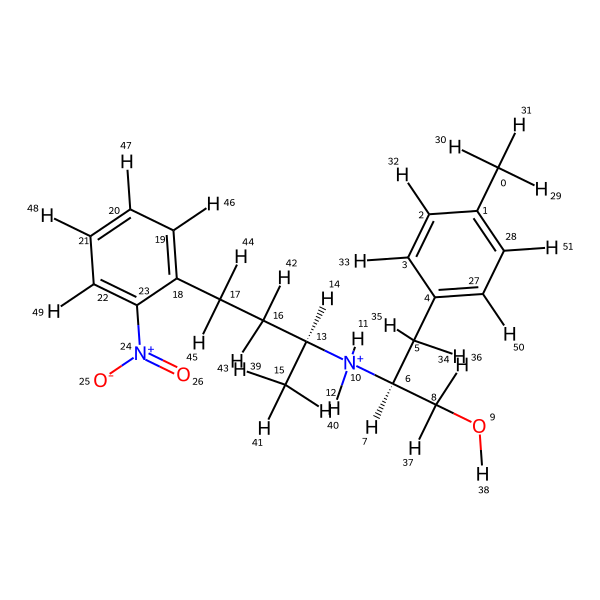

Key, SDF_H: ZINC000159533726


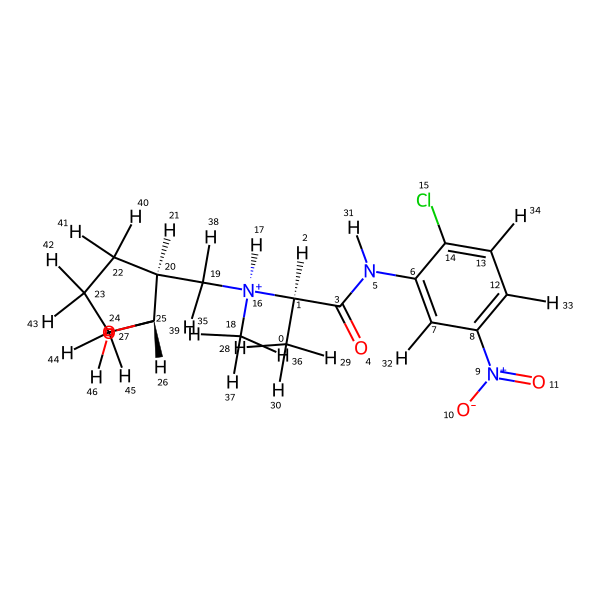

Key, SDF_H: ZINC000151228439


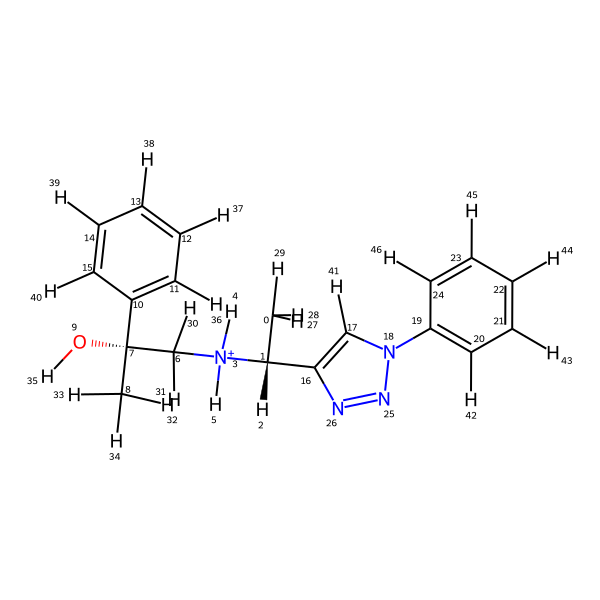

In [75]:
IPythonConsole.molSize = 600,600
IPythonConsole.drawOptions.addAtomIndices = True

# Get the molecules and their keys from the dictionary
mols_only_sdf_H = list(sdf_mols_H.items())

# Draw the molecules in 2D and label their atom numbers
for key_H, mol_H in mols_only_sdf_H:
    # Compute 2D coordinates for the molecule
    AllChem.Compute2DCoords(mol_H)
    
    # Display the key and the molecule
    print(f"Key, SDF_H: {key_H}")
    display(mol_H)

Key, SDF_H: ZINC000191583186


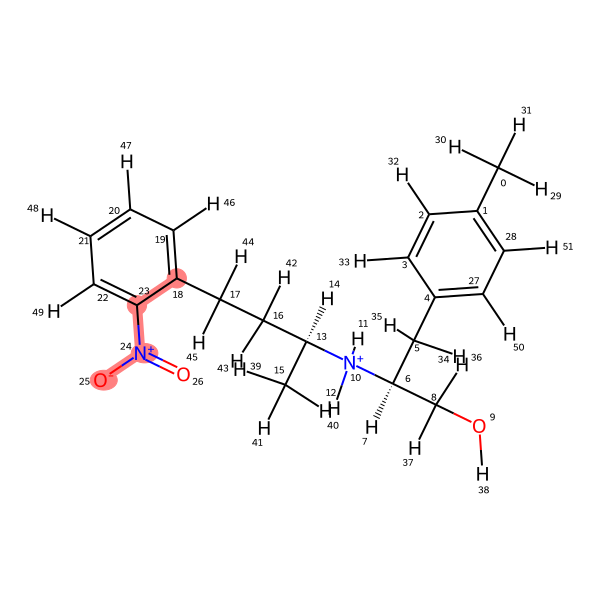

In [92]:
from rdkit import Chem
from rdkit.Chem import Draw, rdFMCS

# Get the first molecule and its key from the dictionary
key_H, mol_H = list(sdf_mols_H.items())[0]

# Define the SMARTS pattern
smarts = '[a:1][a:2]!@[NX3:3][!#1:4]'

# Compute 2D coordinates for the molecule
AllChem.Compute2DCoords(mol_H)

# Find the atoms that match the SMARTS pattern
patt = Chem.MolFromSmarts(smarts)
match = mol_H.GetSubstructMatch(patt)

# Create a temporary copy of the molecule for highlighting
mol_H_temp = Chem.Mol(mol_H)

# Highlight the matching atoms on the temporary copy
mol_H_temp.GetSubstructMatch(patt)

# Display the key and the temporary molecule with the matching atoms highlighted
print(f"Key, SDF_H: {key_H}")
display(mol_H_temp)

Key, MOL2: ZINC000191583186


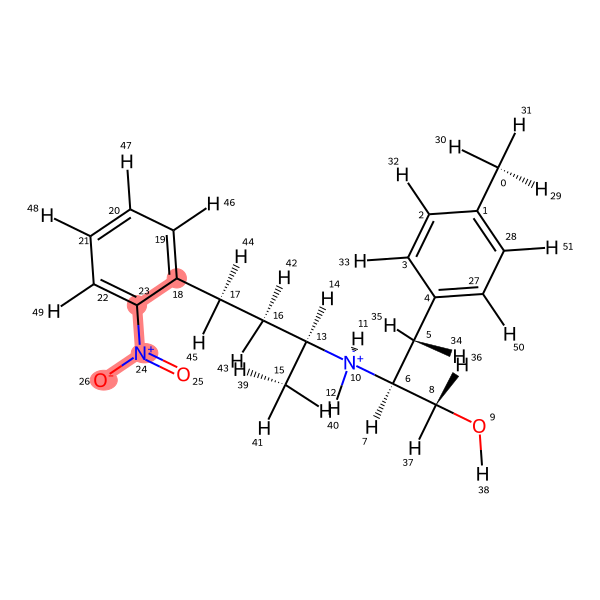

In [93]:
from rdkit import Chem
from rdkit.Chem import Draw, rdFMCS

# Get the first molecule and its key from the mol2_mols dictionary
key_H, mol_H = list(mol2_mols.items())[0]

# Define the SMARTS pattern
smarts = '[a:1][a:2]!@[NX3:3][!#1:4]'

# Compute 2D coordinates for the molecule
AllChem.Compute2DCoords(mol_H)

# Find the atoms that match the SMARTS pattern
patt = Chem.MolFromSmarts(smarts)
match = mol_H.GetSubstructMatch(patt)

# Create a temporary copy of the molecule for highlighting
mol_H_temp = Chem.Mol(mol_H)

# Highlight the matching atoms on the temporary copy
mol_H_temp.GetSubstructMatch(patt)

# Display the key and the temporary molecule with the matching atoms highlighted
print(f"Key, MOL2: {key_H}")
display(mol_H_temp)

As far as I can tell, they do have the same atom index in rdkit. Visually the only difference I can see is that there some weird stereochemistry remaining in the mol2 file. I don't get why the rdkit object from the SDF finds the connection to 18 and the mol2 finds the connection to 22. Like what can be different in the logic? The smarts pattern works for either connection. 

The SMARTS pattern `[a:1][a:2]!@[NX3:3][!#1:4]` is a way to specify a particular substructure in a molecule. Here's what each part of the pattern means:

- `[a:1]` and `[a:2]`: These match any aromatic atom. The `:1` and `:2` are labels that can be used to refer to these atoms in other parts of the pattern.

- `!@`: This matches any bond that is not a ring bond.

- `[NX3:3]`: This matches a nitrogen atom (`N`) with three bonds (`X3`). The `:3` is a label for this atom.

- `[!#1:4]`: This matches any atom that is not a hydrogen atom (`!#1`). The `:4` is a label for this atom.

So, the entire pattern `[a:1][a:2]!@[NX3:3][!#1:4]` matches a structure where two aromatic atoms are connected by a non-ring bond to a nitrogen atom, which is in turn connected to any non-hydrogen atom.

In [ ]:
matches = mol.GetSubstructMatches(Chem.MolFromSmarts(smarts))

Matching atom indices: (18, 23, 24, 26)
Key, MOL2: ZINC000191583186


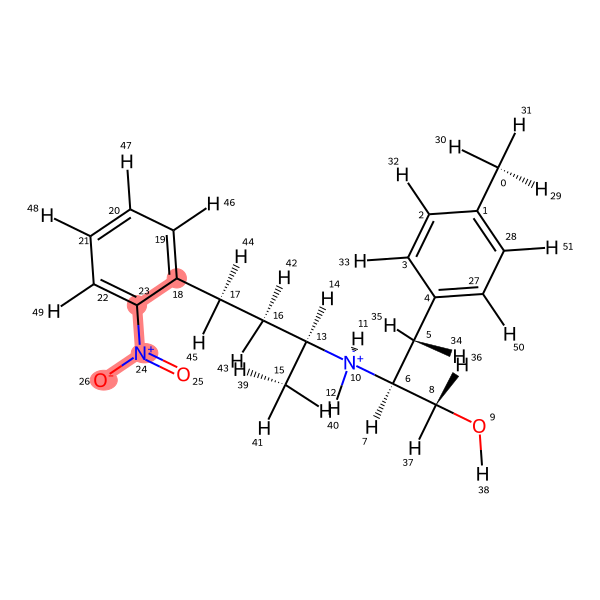

In [94]:
from rdkit import Chem
from rdkit.Chem import Draw, rdFMCS

# Get the first molecule and its key from the mol2_mols dictionary
key_H, mol_H = list(mol2_mols.items())[0]

# Define the SMARTS pattern
smarts = '[a:1][a:2]!@[NX3:3][!#1:4]'

# Compute 2D coordinates for the molecule
AllChem.Compute2DCoords(mol_H)

# Find the atoms that match the SMARTS pattern
patt = Chem.MolFromSmarts(smarts)
match = mol_H.GetSubstructMatch(patt)

# Print the tuple of matching atom indices
print(f"Matching atom indices: {match}")

# Create a temporary copy of the molecule for highlighting
mol_H_temp = Chem.Mol(mol_H)

# Highlight the matching atoms on the temporary copy
mol_H_temp.GetSubstructMatch(patt)

# Display the key and the temporary molecule with the matching atoms highlighted
print(f"Key, MOL2: {key_H}")
display(mol_H_temp)

In [95]:
from rdkit import Chem

# Define a molecule
mol = Chem.MolFromSmiles('c1ccccc1CCc1ccccc1')

# Define a SMARTS pattern
smarts = 'cc'

# Create a molecule object from the SMARTS pattern
pattern = Chem.MolFromSmarts(smarts)

# Find all substructures in the molecule that match the pattern
matches = mol.GetSubstructMatches(pattern)

# Print the matches
for match in matches:
    print(match)

(0, 1)
(0, 5)
(1, 2)
(2, 3)
(3, 4)
(4, 5)
(8, 9)
(8, 13)
(9, 10)
(10, 11)
(11, 12)
(12, 13)


so you very much can find multiple matches as the above example shows, this makes it confusing why our smarts pattern is different from his. he uses the rdkit object and getsubstructmatches function. 

[bond[0] for bond in b_i_r] corresponds to indeces
[bond[1] for bond in b_i_r] corresponds to angles
[bond[2] for bond in b_i_r] corresponds to smarts
[bond[3] for bond in b_i_r] corresponds to hc
[bond[4] for bond in b_i_r] corresponds to methods
[bond[5] for bond in b_i_r] corresponds to E
[bond[6] for bond in b_i_r] corresponds to CI_l
[bond[7] for bond in b_i_r] corresponds to CI_u
[bond[8] for bond in b_i_r] corresponds to flags

i have no idea, all i can think of is turning sanitzation off 